In [10]:
import pandas as pd
import glob
import os

def read_maldi_data(path):
    all_files = glob.glob(path + "/*.csv")
    li = []
    
    for filename in all_files:
        df = pd.read_csv(filename, index_col=0, header=0, sep=";").T
        df['label'] = os.path.basename(filename).split(".")[0]
        li.append(df)
        
    return pd.concat(li)

#pd.read_csv("/home/azareie/maldi_data/0174_03 Fibrotic Tissue.csv", sep=";")

In [11]:
fib = read_maldi_data(r'/ssd/azareie/maldi_data/fib/')
tumor = read_maldi_data(r'/ssd/azareie/maldi_data/tumor/')

In [4]:
fib.to_csv("/ssd/azareie/home_transfer/maldi_fib_spots_merged.csv")
tumor.to_csv("/ssd/azareie/home_transfer/maldi_tumor_spots_merged.csv")

In [12]:
#!source ~/.bashrc; conda activate ml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [13]:
dfproc = tumor.copy()

In [14]:
X = dfproc.loc[:, dfproc.columns != 'label']
y = dfproc.label.values.reshape(-1, 1)
#le = preprocessing.LabelEncoder()
#newx = le.fit_transform(dfproc.group.values)
LE = LabelEncoder()
yenc = LE.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

/usr/lib64/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [136]:
rfmodel = RandomForestClassifier(n_estimators=2000)
rfmodel.fit(x_train,y_train)
y_pred = rfmodel.predict(x_test)
print("y_pred:", y_pred.reshape(1,-1))
print("y_test:", y_test.reshape(1,-1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


y_pred: [['0182_01 Tumor' '0175_01 Tumor' '0182_01 Tumor' ... '0177_01 Tumor'
  '0177_01 Tumor' '0178_01 Tumor']]
y_test: [['0182_01 Tumor' '0175_01 Tumor' '0182_01 Tumor' ... '0177_01 Tumor'
  '0177_01 Tumor' '0178_01 Tumor']]
Accuracy: 0.9956394256070972


In [137]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfmodel.feature_importances_), X.columns), reverse=True)[:5])

Features sorted by their score:
[(0.0214, 172.918914795), (0.0195, 193.85957336400003), (0.0163, 528.315429688), (0.0156, 788.595947266), (0.0156, 766.583007812)]


count    532.000000
mean       0.001880
std        0.002936
min        0.000052
25%        0.000181
50%        0.000640
75%        0.002223
max        0.021378
dtype: float64
172.918915    0.021378
193.859573    0.019540
528.315430    0.016270
766.583008    0.015641
788.595947    0.015619
212.024963    0.015146
175.045410    0.013879
62.016308     0.012642
789.587097    0.012404
885.622192    0.011980
275.018127    0.011654
132.046783    0.011173
500.301422    0.010902
887.631531    0.010598
886.622375    0.010230
311.186737    0.010095
174.045242    0.010054
dtype: float64


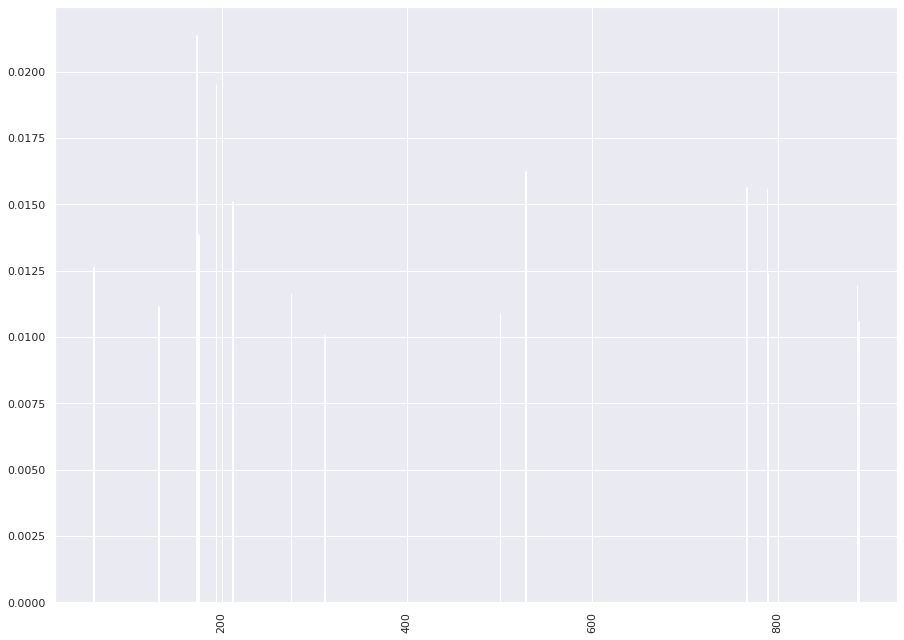

In [138]:
feature_imp = pd.Series(rfmodel.feature_importances_,index=list(X.columns)).sort_values(ascending=False)
most_imp_features = feature_imp[feature_imp > 0.01]
print(feature_imp.describe())
print(most_imp_features)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(most_imp_features.index,most_imp_features)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [107]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

dbscandata = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.1, min_samples=500).fit(dbscandata)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)


[-1 -1 -1 ... -1 -1 -1]


In [110]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

reducer = umap.UMAP(n_neighbors=20)
embedding = reducer.fit_transform((X))
embedding.shape


AttributeError: module 'umap' has no attribute 'UMAP'

/ssd/azareie/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


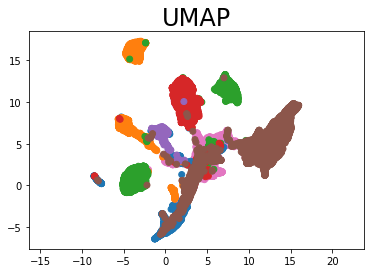

In [12]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in list(yenc)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP', fontsize=24);

LLE: 0.38 sec
LTSA: 2 sec
Hessian LLE: 0.48 sec
Modified LLE: 0.3 sec
Isomap: 0.58 sec
MDS: 2.2 sec
SE: 0.88 sec
t-SNE: 1.5e+03 sec


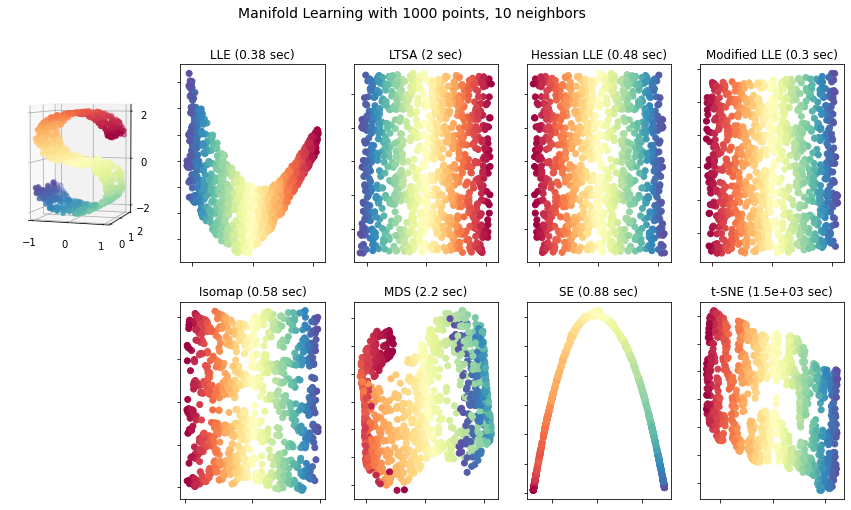

In [18]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

LLE: 88 sec


/home/azareie/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:937: LinAlgWarning: Diagonal number 2 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


LTSA: 59 sec
Modified LLE: 82 sec
Isomap: 1.9e+02 sec
MDS: 5.7e+02 sec
SE: 61 sec


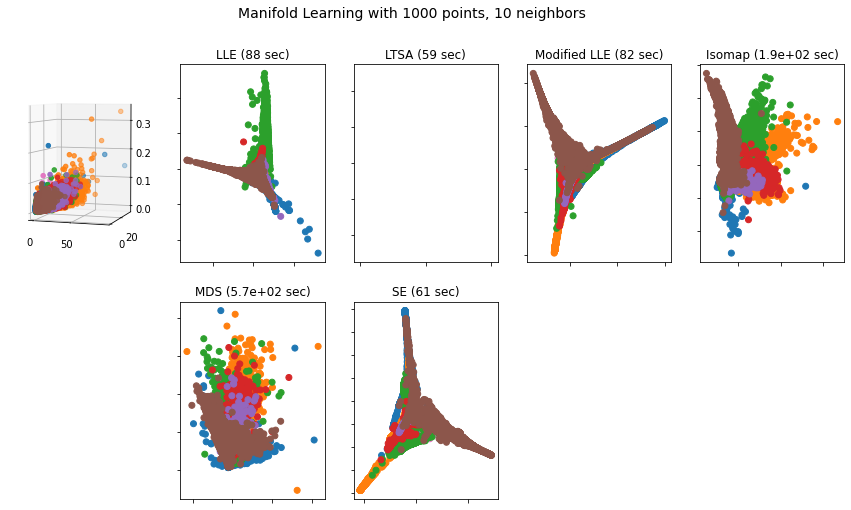

In [40]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
#X = X.to_numpy()
#X, color = datasets.make_s_curve(n_points, random_state=0)
color=[sns.color_palette()[x] for x in list(yenc)]
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
#methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
#methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
#                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

In [27]:
from sklearn.datasets import load_digits
X, y = load_digits().data, load_digits().target
from cuml.manifold import TSNE
tsne = TSNE(n_components = 2)
X_hat = tsne.fit_transform(X)

# To plot the embedding
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_hat[:,0], X_hat[:,1], c = y, s = 0.5)

ImportError: libcuml.so: cannot open shared object file: No such file or directory

In [37]:
X.to_numpy()

array([[6.43244886, 2.06735182, 0.01835152, ..., 1.13078535, 0.68289977,
        0.50052387],
       [9.61403561, 3.15609837, 0.05504658, ..., 0.90915835, 0.57565641,
        0.93751144],
       [5.07755852, 1.62593603, 0.02092792, ..., 0.9825393 , 0.78678906,
        0.67850614],
       ...,
       [5.78303957, 1.96666765, 0.02120026, ..., 0.68019181, 0.39251447,
        0.42707694],
       [4.96917391, 1.55245614, 0.01067199, ..., 0.68267763, 0.37965167,
        0.35201508],
       [4.3187809 , 1.37766087, 0.01546856, ..., 0.46473649, 0.4206045 ,
        0.24389353]])

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

maldiColors = pd.read_csv("/ssd/azareie/Python_colors.csv")
maldiFullmap = pd.read_csv("/ssd/azareie/Python_fullmap.csv",index_col=0)
maldiSpots = pd.read_csv("/ssd/azareie/Python_dfspots.csv")

In [15]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

import sklearn
print(sklearn.__version__)

0.21.3


In [3]:
X, y = load_digits(return_X_y=True)

In [ ]:
tsneModel = TSNE(perplexity=50, n_iter=10000, n_iter_without_progress=3500, n_jobs=-3)
X_embedded = tsneModel.fit_transform(X)

In [ ]:
tsneModel = TSNE()
X_embedded = tsneModel.fit_transform(X)

In [ ]:
p0 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y.ravel(), legend='full');
p0.figure.savefig("sample_iter10k_perplexity50.pdf")

In [ ]:
p0 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y.ravel(), legend='full');
p0.figure.savefig("tumor_tsne_rerun_default_param.pdf")

In [ ]:
import dill
dill.dump_session('maldi_env_default_tsne_rerun.db')

In [19]:
np.unique(y)

/ssd/azareie


In [61]:
from pandas import ExcelFile

df = pd.read_excel('/home/azareie/PRIMUS/data/18_lab/MALDI Imaging/SOM & tSNE/experimental groups.xlsx')
print(df)

ygroups = y.copy()
ygroups = ygroups.ravel()
ygroups[ygroups == '0174_03 Fibrotic Tissue'] = "TG1"
ygroups[ygroups == '0175_03 Fibrotic Tissue'] = "BM1"
ygroups[ygroups == '0177_03 Fibrotic Tissue'] = "CTR"
ygroups[ygroups == '0178_03 Fibrotic Tissue'] = "CTR"
ygroups[ygroups == '0179_03 Fibrotic Tissue'] = "TG1"
ygroups[ygroups == '0182_03 Fibrotic Tissue'] = "BM1"
ygroups[ygroups == '0184_03 Fibrotic Tissue'] = "TG1"

In [ ]:
ygroups = y.copy()
ygroups = ygroups.ravel()
ygroups[ygroups == '0174_01 Tumor'] = "TG1"
ygroups[ygroups == '0175_01 Tumor'] = "BM1"
ygroups[ygroups == '0177_01 Tumor'] = "CTR"
ygroups[ygroups == '0178_01 Tumor'] = "CTR"
ygroups[ygroups == '0179_01 Tumor'] = "TG1"
ygroups[ygroups == '0182_01 Tumor'] = "BM1"
ygroups[ygroups == '0184_01 Tumor'] = "TG1"

In [ ]:
p = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=ygroups, legend='full');
p.figure.savefig("group_iter10k_perplexity50.pdf")

In [79]:
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(x_train)

# Scale the train set
x_train = scaler.transform(x_train)

# Scale the test set
x_test = scaler.transform(x_test)

In [90]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(532, activation='relu', input_shape=(532,)))

# Add hidden layers
model.add(Dense(250, activation='relu'))

model.add(Dense(80, activation='relu'))

model.add(Dense(20, activation='relu'))

# Add an output layer 
model.add(Dense(7, activation='softmax'))

In [ ]:
X = dfproc.loc[:, dfproc.columns != 'label']
y = dfproc.label.values.reshape(-1, 1)
le = preprocessing.LabelEncoder()
newy = le.fit_transform(dfproc.label.values)
x_train, x_test, y_train, y_test = train_test_split(X, newy, test_size=0.40)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(x_train, y_train, epochs=500, batch_size=100, verbose=1)

In [92]:
y_pred = model.predict(x_test)
print(y_pred)
print(y_test)

score = model.evaluate(x_test, y_test,verbose=1)
print(score)

print(newy)
print(y)

[[0.0000000e+00 1.6473817e-38 2.8622010e-28 ... 9.1330605e-26
  0.0000000e+00 3.9568454e-36]
 [1.0000000e+00 2.9043191e-25 1.9440200e-35 ... 6.6454006e-22
  2.8245395e-30 3.1038028e-25]
 [3.9184392e-35 1.0000000e+00 8.6637081e-20 ... 2.1472258e-35
  5.0172637e-37 1.5405560e-24]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.4416844e-34 ... 3.2007275e-33
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.7617644e-37 ... 6.4497612e-32
  0.0000000e+00 0.0000000e+00]]
[3 0 1 ... 2 3 3]
5478/5478 [==============================] - 0s 42us/step
[0.10981505636512419, 0.9979919791221619]
[0 0 0 ... 6 6 6]
[['0174_03 Fibrotic Tissue']
 ['0174_03 Fibrotic Tissue']
 ['0174_03 Fibrotic Tissue']
 ...
 ['0184_03 Fibrotic Tissue']
 ['0184_03 Fibrotic Tissue']
 ['0184_03 Fibrotic Tissue']]


In [2]:
import pandas as pd
import numpy as np

tumor_matrix = pd.read_csv("/home/azareie/entire_tumor_image_for_scipy.csv", index_col=0)
#tumor_matrix['x'] = (tumor_matrix.x + 100000) * (10**20)
#tumor_matrix['y'] = (tumor_matrix.y + 100000) * (10**20)

#tumor_matrix['x'] = tumor_matrix['x'] - np.min(tumor_matrix['x'])
#tumor_matrix['y'] = tumor_matrix['y'] - np.min(tumor_matrix['y'])

In [56]:
#https://stackoverflow.com/questions/44594239/python-filling-in-missing-data-in-an-iterative-dataset

4.4761913572999997e+24

In [12]:
tumor_matrix.sort_values(['x', 'y'], ascending=[False, False])

,x,y,color
Spot 83572,4.47619e+24,1.37919e+24,#E5D8BD
Spot 83573,4.47579e+24,1.38418e+24,#E5D8BD
Spot 83574,4.47538e+24,1.38916e+24,#E5D8BD
Spot 83575,4.47498e+24,1.39414e+24,#E5D8BD
Spot 83576,4.47457e+24,1.39913e+24,#E5D8BD
...,...,...,...
Spot 11833,7.38306e+21,5.44728e+23,#E5D8BD
Spot 11610,6.58716e+21,5.33662e+23,#000000
Spot 11722,4.65674e+21,5.38233e+23,#E5D8BD
Spot 11832,2.72632e+21,5.42803e+23,#66C2A5


In [57]:
# Set dimensions (assumes square grid)
dim = np.max([np.max(tumor_matrix.x),np.max(tumor_matrix.y)])

# Missing data value
no_data = "#ffffff"

# Assign data to vectors
X = tumor_matrix['x'].tolist()
Y = tumor_matrix['y'].tolist()
Z = tumor_matrix['color'].tolist()

# Iterate over the vector X
# If the modulo 10 of the index (which will cycle over 10),
# falls out of order with the value of X at that index 
# (which also cycles over 10), then insert missing values 
for i in range(1, np.size(X)):
    if (i % dim + 1) != int(X[i]):
        X.insert(i, (i % dim + 1))
        Y.insert(i, Y[i])
        Z.insert(i, no_data)

In [ ]:
sampleData = "https://www.dropbox.com/s/xvn8a06x5abtvz8/DATA_TMP.csv?dl=1"
df_matrix = pd.read_csv(sampleData, index_col=0)

# you only want to change `color` column
df_matrix.loc[df_matrix.color == 'black', 'color'] = '#000000'

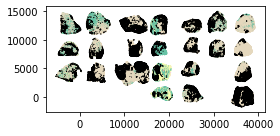

In [3]:
#https://stackoverflow.com/questions/39753282/scatter-plot-with-single-pixel-marker-in-matplotlib


import matplotlib.pyplot as plt
import webcolors

plotcolors = [[webcolors.hex_to_rgb(col)[0]/255,webcolors.hex_to_rgb(col)[1]/255,webcolors.hex_to_rgb(col)[2]/255] for col in tumor_matrix.color]

fig = plt.figure(figsize=(4,2))
#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)
#plt.plot(tumor_matrix.x, tumor_matrix.y, marker='o',ms=72./fig.dpi, mew=0,  color=plotcolors, linestyle="", lw=0)
#ax.set_title("ax.plot")
#ax2.scatter([1,2],[0.4,0.4],color='black', marker='o', lw=0, s=(72./fig.dpi)**2)

#plt.scatter(tumor_matrix.x, tumor_matrix.y,color=plotcolors,marker=',',lw=0, s=1)
plt.scatter(tumor_matrix.x, tumor_matrix.y, color=tumor_matrix.color, marker='o', lw=0, s=(72./fig.dpi)**2)

#ax2.set_title("ax.scatter")
#ax.set_xlim(0,8)
#ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig('plotO_4x2.png', dpi=fig.dpi);


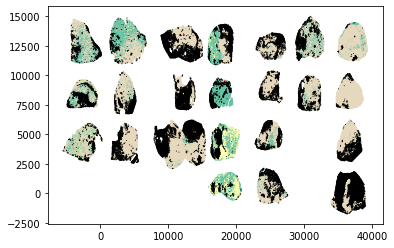

In [29]:
plt.scatter(tumor_matrix.x,tumor_matrix.y,color=tumor_matrix.color, marker='o', lw=0, s=(72./fig.dpi)**2)
plt.savefig('72dpi_tumor.png')

In [6]:
import matplotlib.pyplot as plt

plt.ioff()

fig = plt.figure(figsize=(16,7.65), dpi = 800)
plt.scatter(tumor_matrix.x, tumor_matrix.y, color=tumor_matrix.color, marker='s', lw=0, s=1)
plt.tight_layout()
plt.savefig('plot__test_s_800dpi.png', dpi=fig.dpi);


0.0012959999999999998